# 02_NBS_ Arima Model (Time-Series) Forecasting

## Purpose

The purpose of this notebook is to build ARIMA model and deep diving about ARIMA model.

## Methodology
The approach used to made this experiment are: find the orders parameters (p, q, d), build ARIMA model, use AUTO ARIMA model, plot the projection of forecasting result.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- Find the order parameters (p, q, d);
- Build ARIMA model;
- Use AUTO ARIMA Model.

## Results
To do.

## Suggested next steps
To do.

# Setup 
## Library Import

In [61]:
# Data Manipulation
import numpy as np
import pandas as pd

# Statistica Librarys
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

# Plot visualization
import matplotlib.pyplot as plt

%matplotlib inline

## Local Library Import

In [2]:
import os

## Parameter Definition

In [3]:
DATA_PATH = "../data/second_dataset.csv"

# Data Import

In [148]:
df = pd.read_csv(DATA_PATH)
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [149]:
df.shape

(204, 2)

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    204 non-null    object 
 1   value   204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [151]:
df["date"] = pd.to_datetime(df["date"])

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB


# Data Preprocessing

## Test stationary using ADF Test

* **H0**: assume the time-series are non-stationary;

In [8]:
result = adfuller(df.value.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")

ADF Statistic: 3.145185689306744
P-value: 1.0


Since p-value (1.00) is greater than the threshold level (0.05), we have to diffrence the sereis and see how the autocorrelation plot looks like.

## Plot Autocorrelation

In [30]:
def plot_autocorrelation(df: pd.DataFrame):
    """ This function plot the differences until thrid differencing.

    Arguments:
        df (pd.DataFrame): Dataframe contained the time-series feature.
    """

    fig, ax = plt.subplots(4, 2, figsize=(20, 10), dpi=120)
    ax[0, 0].plot(df.value); ax[0, 0].set_title("Original Time Series")
    plot_acf(df.value, ax=ax[0, 1])

    # 1st Differencing
    ax[1, 0].plot(df.value.diff()); ax[1, 0].set_title("1st Order Differencing")
    plot_acf(df.value.diff().dropna(), ax=ax[1, 1])


    # 2nd Differencing
    ax[2, 0].plot(df.value.diff().diff()); ax[2, 0].set_title("2nd Order Differencing")
    plot_acf(df.value.diff().diff().dropna(), ax=ax[2, 1])


    # 3rd Differencing
    ax[3, 0].plot(df.value.diff().diff().diff()); ax[3, 0].set_title("3rd Order Differencing")
    plot_acf(df.value.diff().diff().diff().dropna(), ax=ax[3, 1])

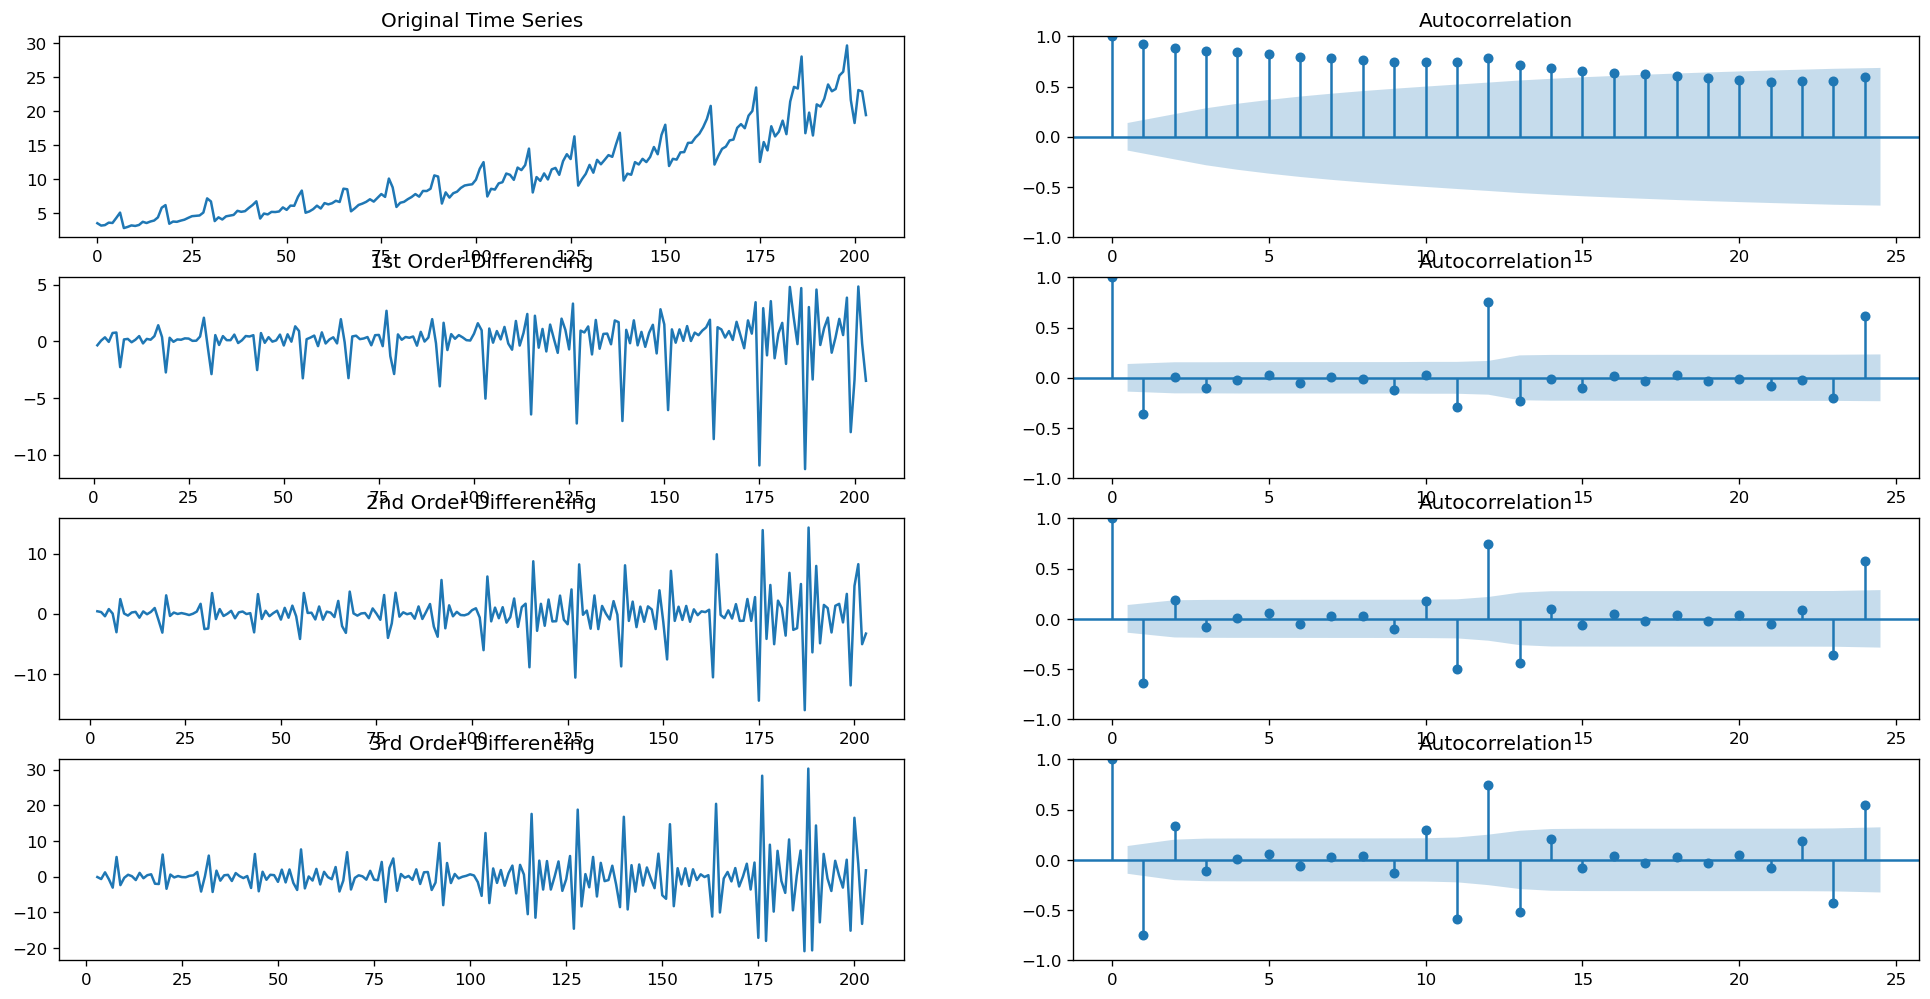

In [31]:
plot_autocorrelation(df)

We can see the time-series reaches stationarity with two orders of differecing

## Find the orders parameters (p, q, d)

**Find the p term using Partial Autocorrelation**

In [49]:
def find_order_parameters(parameter: str):
    if (parameter == 'p'):
        fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=120, sharex=True)
        ax[0].plot(df.value.diff()); ax[0].set_title("1st Differecing")
        ax[1].set(ylim=(0, 5))
        plot_pacf(df.value.diff().dropna(), ax=ax[1])
    elif (parameter == 'q'):
        fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 6), dpi=120)
        ax[0].plot(df.value.diff()); ax[0].set_title("1st Differencing")
        ax[1].set(ylim=(0, 1.2))
        plot_acf(df.value.diff().dropna(), ax=ax[1])
    plt.show()

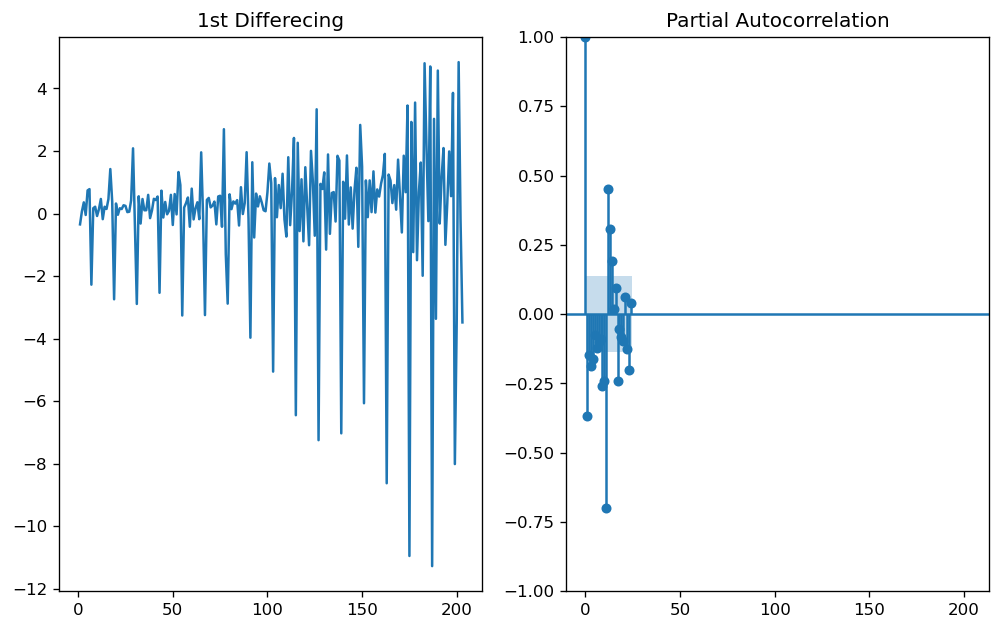

In [44]:
find_order_parameters(parameter='p')

The lag 1 is quite significant, so we will fix the value of p as 1.

**Find the q term using Autocorrelation**

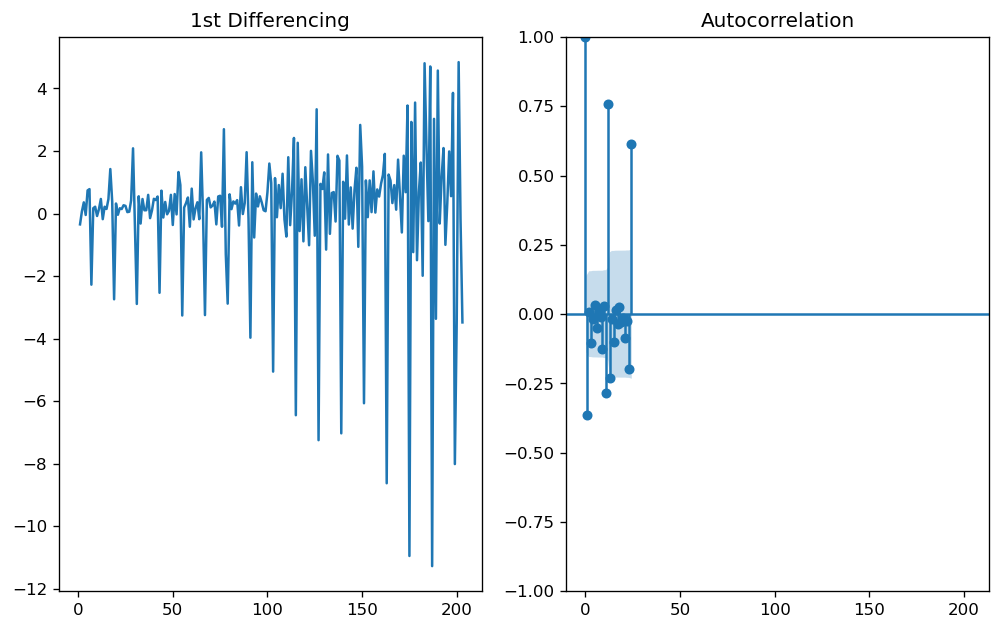

In [50]:
find_order_parameters(parameter='q')

We will set the q as 2, because the couple of lags are weel above the significance level

# Build ARIMA Model

In [153]:
df_data = df.copy()

In [154]:
df_data = df_data.set_index("date")
df_data.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [155]:
df_data.index = pd.DatetimeIndex(df_data.index.values,
                               freq=df_data.index.inferred_freq)

In [156]:
model = ARIMA(df_data, order=(1, 1, 2))
history = model.fit()
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Mon, 10 Apr 2023   AIC                            857.140
Time:                        11:47:29   BIC                            870.393
Sample:                    07-01-1991   HQIC                           862.502
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.722      -0.437       0.631
sigma2         3.8259      0.269     14.209      0.000       3.298       4.354
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               135.61
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               9.82   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We have to rebuild the model without the MA2 term, because is great than significance value (0.05)

In [157]:
model = ARIMA(df_data, order=(1, 1, 1))
history = model.fit()
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Mon, 10 Apr 2023   AIC                            855.524
Time:                        11:47:48   BIC                            865.463
Sample:                    07-01-1991   HQIC                           859.545
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.000       3.325       4.341
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):               130.26
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               9.98   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Plot Residuals to ensure there are no patterns**

In [158]:
def plot_residuals(residual):
    """This function plot the residual of the ARIMA model
    
    Arguments:
        residual: the residual of the ARIMA model
    """
    df_res = pd.DataFrame(residual)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=120)
    df_res.plot(title="Residuals", ax=ax[0])
    df_res.plot(kind="kde", title="Density", ax=ax[1])
    plt.show()

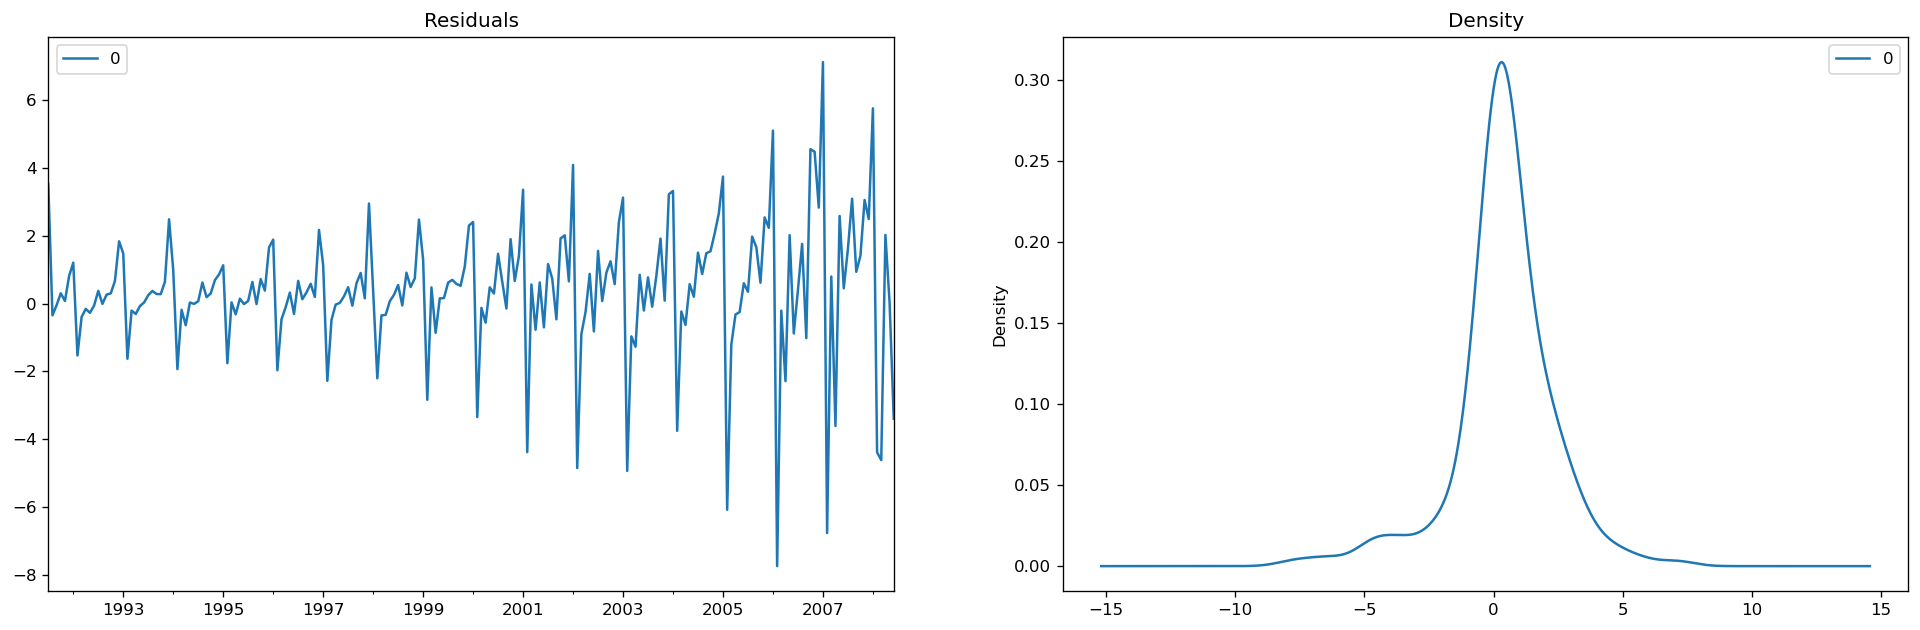

In [159]:
plot_residuals(history.resid)

The residual errors seem fine with near zero mean and uniform variance.

# Plot the fitted values

In [160]:
def plot_fitted_values(df, history):
    """This function plot the fitted values
    
    Arguments:
        df: DataFrame
        history: the fitten values
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax = df.loc["1991-07-01": ].plot(ax=ax)
    plot_predict(history, "2007", "2008-06-01", ax=ax)
    plt.show()

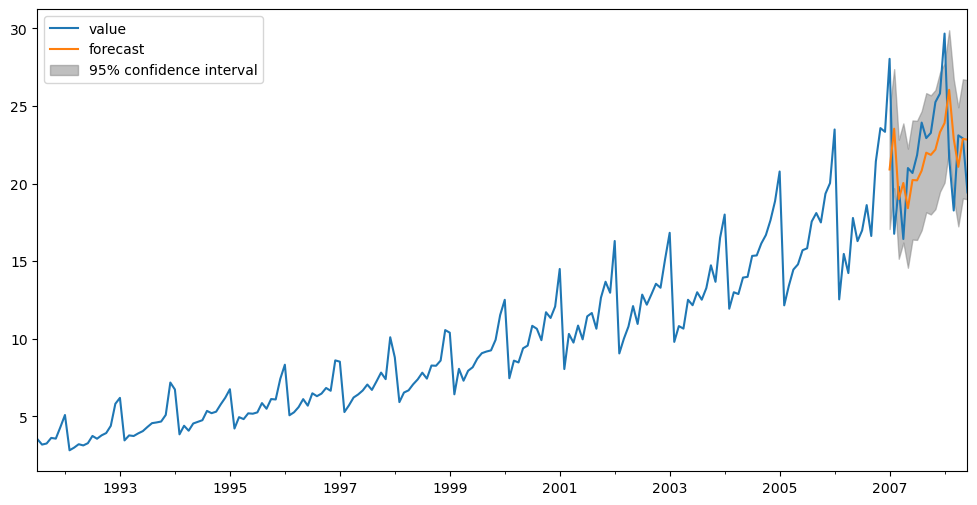

In [161]:
plot_fitted_values(df_data, history)